In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Data

I created an entrapment exeperiment as follows. 

I performed an open ionbot and msfragger search (oxididation of M variable, max 2 missed cleavages).

In [25]:
#set this your local folder as the data was pushed to the repo as well
folder = "/home/compomics/tools/ionbot_paper"
datasets = ["PXD001468","PXD000561","PXD000815","PXD001250","TMTCPTAC","pyrococcus"]
#datasets = ["pyrococcus"]

 # Results
 
Load ionbot PSM results (first-matches + coeluting matches + features) + protein results.

In [26]:
def contains_missed_cleavage(x):
    if "K" in x[:-1]:
        return True
    if "R" in x[:-1]:
        return True
    return False

def is_in_s(x):
    return x in s

def is_target(x):
    tmp = x.split('||')
    for t in tmp:
        #if not "SHUFFLED" in t:
        if not "ENTRAPMENT" in t:
            return True
    return False

def is_target2(x):
    tmp = x.split(',')
    for t in tmp:
        if t == "nan":
            continue
        #if not "SHUFFLED" in t:
        if not "ENTRAPMENT" in t:
            return True
    return False

In [33]:
results = []
for dataset in datasets:
    print(dataset)
    dataset = dataset + "_A"
    #Processing dataset
    if "PXD001468" in dataset:
        def get_scan_ionbot(x):
            return int(x.split('.')[1])
        def get_spectrum_file_ionbot(x):
            return x.split('.')[0]
    else:
        def get_scan_ionbot(x):
            print(x)
            return int(x.split('=')[-1])
        def get_spectrum_file_ionbot(x):
            return x.split('.')[0]
    folder2 = folder + "/" + dataset
    ionbot = pd.read_csv("%s/ionbot.first.csv"%folder2)
    ionbot["rank"] = ["first"]*len(ionbot)
    tmp = pd.read_csv("%s/ionbot.lower.csv"%folder2)
    tmp["rank"] = ["lower"]*len(tmp)
    ionbot = pd.concat([ionbot,tmp])
    #NO IDEA WHAT HAPPENED HERE...
    ionbot = ionbot.drop_duplicates("ionbot_match_id")
    tmp = pd.read_csv("%s/ionbot.features.csv"%folder2)
    ionbot = ionbot.merge(tmp,on="ionbot_match_id",how="left")
    ionbot = ionbot[(ionbot["database"]=="T")&(ionbot["q-value"]<=0.01)]
    if "PXD001468" in dataset:
        ionbot["scan"] = ionbot["spectrum_title"].apply(get_scan_ionbot)
        ionbot["sfile"] = ionbot["spectrum_title"].apply(get_spectrum_file_ionbot)
    else:
        ionbot["sfile"] = ionbot["spectrum_file"].apply(get_spectrum_file_ionbot)
    ionbot["PSM"] = ionbot["scan"].astype(str) + ionbot["sfile"] +  "XYX" +  ionbot["matched_peptide"]
    ionbot["contains_missed_cleavage"] = ionbot["matched_peptide"].apply(contains_missed_cleavage)    
    ionbot["num_passed"] = ionbot.groupby(["sfile","scan"])["scan"].transform("count")
    ionbot = ionbot[(ionbot["num_passed"]==1) |
            (ionbot["rank"]=="lower") |
            ((ionbot["num_passed"]>1) & (ionbot["rank"]=="first") & (ionbot["unexpected_modification"].isna()) & (ionbot["contains_missed_cleavage"]==False))]
    #need to re-assign best_psm
    best_psms = ionbot.sort_values("psm_score").drop_duplicates(["sfile","scan"], keep="last")
    best_psm_ids = set(best_psms["ionbot_match_id"])
    if dataset != "pyrococcus_A":
        ionbot["rank"] = ionbot["ionbot_match_id"].apply(
        lambda x: "first" if x in best_psm_ids else "lower")    
    ionbot["is_target"] = ionbot["proteins"].apply(is_target)

    #tmp = ionbot.sort_values("psm_score",ascending=False)
    #ranks = list(tmp["rank"])
    #hits = list(tmp["is_target"])
    #qs = list(tmp["q-value"])
    #X = []
    #c_first = 0
    #c_lower = 0
    #for i in range(len(ranks)):
    #    if hits[i] == False:
    #        if ranks[i] == "first":
    #            c_first += 1
    #            X.append([qs[i],c_first/(i+1),"ionbot first"])
    #        else:
    #            X.append([qs[i],c_lower/(i+1),"ionbot lower"])
    #            c_lower += 1
    #ionbot_fdr = pd.DataFrame(X,columns=["q-value","Entrapment FDR","type"])
    ionbot["is_target_r"] = 1 - ionbot["is_target"]
    tmp1 = ionbot[ionbot["rank"]=="first"].sort_values(["q-value","is_target_r"]) #I cannot use score as it is not the same for higher and lower
    tmp2 = ionbot[ionbot["rank"]=="lower"].sort_values(["q-value","is_target_r"])
    l1 = list(tmp1["is_target"])
    l2 = list(tmp1["q-value"])
    X = []
    c = 0
    for i in range(len(l1)):
        if l2[i] > 0.01: break
        if l1[i] == False:
            c += 1
        X.append([l2[i],c/(i+1)])
    print(c)
    print(i)
    print(c/(i+1))
    d1 = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])
    d1["type"] = ["ionbot first"]*len(d1)
    l1 = list(tmp2["is_target"])
    l2 = list(tmp2["q-value"])
    X = []
    c = 0
    with open("t.txt","w") as f:
        for i in range(len(l1)):
            if l2[i] > 0.01: break
            if l1[i] == False:
                c += 1
            X.append([l2[i],c/(i+1)])
            f.write("%f %i %f\n"%(X[-1][0],c,c/(i+1)))
    d2 = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])
    d2["type"] = ["ionbot lower"]*len(d2)
    ionbot_fdr = pd.concat([d1,d2])

    #MSFragger
    if dataset == "PXD001468":
        fragger = pd.read_csv("%s/msfragger/%s/psm.tsv"%(folder,dataset),sep="\t")
    else:
        fragger = pd.read_csv("%s/msfragger/%s/noprotein/psm.tsv"%(folder,dataset),sep="\t")
    fragger["proteins_all"] = fragger["Protein"].astype(str) + ',' + fragger["Mapped Proteins"].astype(str)
    fragger["is_target"] = fragger["proteins_all"].apply(is_target2)
    fragger["is_target"].value_counts()
    efdr = len(fragger[fragger["is_target"]==False]) / len(fragger[fragger["is_target"]==True]) 
    fragger_full_fdr = pd.DataFrame([[0.01,efdr,"MSFragger Prophet"]],columns=["q-value","Entrapment FDR","type"])
    c = 0
    e = 0
    X = []
    with open("%s/msfragger/%s/o"%(folder,dataset)) as f:
        f.readline()
        for row in f:
            l = row.rstrip().split('\t')
            if float(l[2]) > 0.01: break
            c += 1
            ok = False
            for t in l[5:]:
                if not "ENTRAPMENT" in t:
                    ok = True
            if ok == False:
                e += 1
            X.append([float(l[2]),e / c])
    fragger_fdr = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])
    fragger_fdr["type"] = ["MSFragger Percolator"]*len(fragger_fdr)
    tmp = pd.concat([ionbot_fdr,fragger_fdr,fragger_full_fdr])
    tmp["dataset"] = [dataset]*len(tmp)
    results.append(tmp)
    

PXD001468
3568
689050
0.005178136306311144
PXD000561
1195
266468
0.004484574190618796
PXD000815
350
81023
0.004319707740916272
PXD001250
2047
406791
0.005032055694310606
TMTCPTAC
2067
432158
0.0047829618265499505
pyrococcus
17
7356
0.002310724480086992


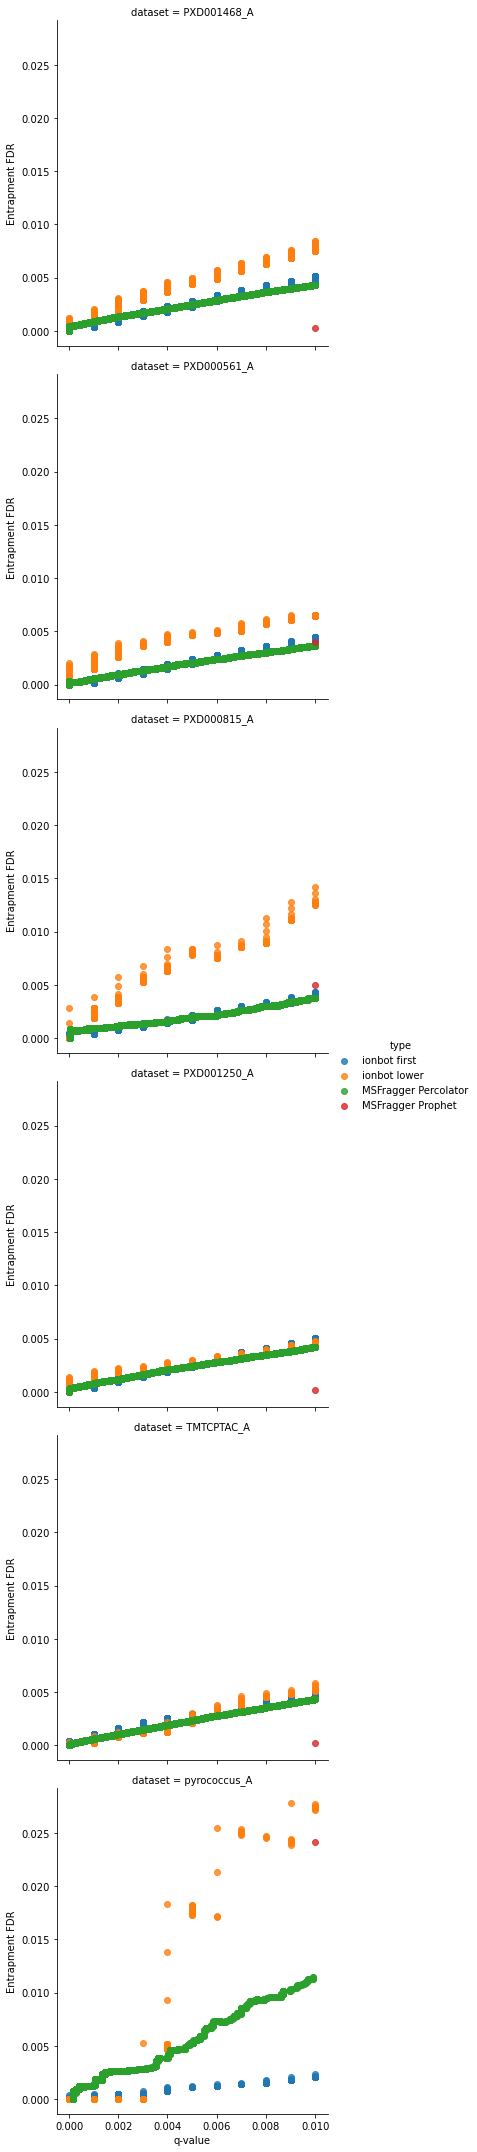

In [28]:
tmp = pd.concat(results)
sns.lmplot(x="q-value",y="Entrapment FDR",hue="type", row="dataset",data=tmp,fit_reg=False)

In [29]:
tmp.to_csv("entrapment_archaea.csv",index=False)